In [1]:
import numpy as np
import healpy as hp
import pymaster as nmt
from scipy import optimize
from scipy.linalg import det
import matplotlib.pyplot as plt

In [2]:
nside=256
freqs=np.arange(544,1088,step=1)
# nfreqs=len(freqs)
nfreqs=181
lmax=3*nside -1
almsize=hp.Alm.getsize(lmax)

In [54]:
smoothed_hi_maps=np.load("smoothed_hi_maps.npy") #first chunk nf=181
smoothed_maps= np.load("smoothed_maps_1_smallbeam.npy") #first chunk
noise_maps= np.load("noise_nf.npy")

In [55]:
noise_maps_1=noise_maps[:181] # take only first chunk

We observe $$x_\ell = s_\ell + n_\ell + f_\ell$$
The Model Covariance is written as:
$$C_\ell^{\text{model}} = C_{\text{HI}} + C_{\text{noise}} + F P_\ell F^T$$
Where:

- $F \in \mathbb{R}^{N_c \times r}$: foreground mixing matrix (unknown)
- $P_\ell \in \mathbb{R}^{r \times r}$: power spectra of foreground components at multipole ℓ (unknown)
- $r≪N_c$: the rank of the foreground model

$N_c$ is the number of channels (frequency bins), 
and $r$ is the foreground model rank $\approx 3$

In [241]:
def compute_cl(almmaps:np.ndarray, l_max: int, n_freq: int)-> tuple[np.ndarray, np.ndarray]:
    r"""
    Compute the power spectrum C_l from alm_maps.

    The power spectrum is computed as:

    \[ \hat{C}_{l}^{ij} = \frac{1}{2l+1}\sum_{m=-l}^{+l} a_{lm}^{i}a^{j \dagger }_{lm} \]
    
    Parameters:
    ----------
    almmaps : np.ndarray
        Array of shape (n_freq, num_alm) containing spherical harmonic coefficients.
    
    l_max : int
        Maximum multipole lmax.
    
    n_freq : int
        Number of frequency channels.
    
    Returns:
    -------
    alm_p : np.ndarray
        Truncated spherical harmonic values for m>0.
    
    C_l : np.ndarray
        Power spectrum array of shape (lmax+1, n_freq, n_freq).
    """
    Cl = np.zeros((l_max + 1, n_freq, n_freq), dtype=float)
    
    for l in range(l_max + 1):
        
        index = np.zeros((l + 1), dtype=int)
        
        for m in range(l + 1):
            index[m] = hp.Alm.getidx(l_max, l, m)  # Get Alm index
        
        almp = almmaps[:, index]  # Extract relevant alm values
        print(f"Computing power spectra {l}")
        # Compute C_l
        Cl[l, :, :] = np.real(np.outer(almp[:, 0], almp[:, 0]))
        
        for m in range(1, l + 1):  # Sum over m
            Cl[l, :, :] += 2 * np.real(np.outer(almp[:, m], np.conj(almp[:, m])))
        Cl[l]/=(2 * l + 1)  # Normalize by 2l+1
    
    return Cl

In [242]:
def compute_covariance(maps, lmax, almsize, nfreqs):
    alms=np.zeros((nfreqs, almsize), dtype=complex) 
    
    for nf in range(nfreqs):
        print(f"Converting maps {nf}")
        alms[nf,:]= hp.map2alm(maps[nf,:], lmax=lmax) 
        
    cl=compute_cl(alms, lmax, nfreqs)
    
    return cl

In [243]:
# Getting the model covariance of HI and noise which we assume to be known
# F and P_l are free parameters to be estimated

cl_noise= compute_covariance(noise_maps_1, lmax, almsize, nfreqs)
cl_hi= compute_covariance(smoothed_hi_maps, lmax, almsize, nfreqs)

Converting maps 0
Converting maps 1
Converting maps 2
Converting maps 3
Converting maps 4
Converting maps 5
Converting maps 6
Converting maps 7
Converting maps 8
Converting maps 9
Converting maps 10
Converting maps 11
Converting maps 12
Converting maps 13
Converting maps 14
Converting maps 15
Converting maps 16
Converting maps 17
Converting maps 18
Converting maps 19
Converting maps 20
Converting maps 21
Converting maps 22
Converting maps 23
Converting maps 24
Converting maps 25
Converting maps 26
Converting maps 27
Converting maps 28
Converting maps 29
Converting maps 30
Converting maps 31
Converting maps 32
Converting maps 33
Converting maps 34
Converting maps 35
Converting maps 36
Converting maps 37
Converting maps 38
Converting maps 39
Converting maps 40
Converting maps 41
Converting maps 42
Converting maps 43
Converting maps 44
Converting maps 45
Converting maps 46
Converting maps 47
Converting maps 48
Converting maps 49
Converting maps 50
Converting maps 51
Converting maps 52
Con

Diagonalize the power spectra, so we have $C^{ii}(l)$ 

In [244]:
def diagonalize_matrices(cl, nfreqs):
    cl_diag=np.zeros((lmax+1, nfreqs, nfreqs))
    for l in range (lmax+1):
        print(f"Diagonalizing matrix {l}")
        cl_diag[l,:,:]= np.identity(nfreqs)*cl[l,:,:]
    return cl_diag

In [245]:
hi= diagonalize_matrices(cl_hi, nfreqs)
noise= diagonalize_matrices(cl_noise, nfreqs)

Diagonalizing matrix 0
Diagonalizing matrix 1
Diagonalizing matrix 2
Diagonalizing matrix 3
Diagonalizing matrix 4
Diagonalizing matrix 5
Diagonalizing matrix 6
Diagonalizing matrix 7
Diagonalizing matrix 8
Diagonalizing matrix 9
Diagonalizing matrix 10
Diagonalizing matrix 11
Diagonalizing matrix 12
Diagonalizing matrix 13
Diagonalizing matrix 14
Diagonalizing matrix 15
Diagonalizing matrix 16
Diagonalizing matrix 17
Diagonalizing matrix 18
Diagonalizing matrix 19
Diagonalizing matrix 20
Diagonalizing matrix 21
Diagonalizing matrix 22
Diagonalizing matrix 23
Diagonalizing matrix 24
Diagonalizing matrix 25
Diagonalizing matrix 26
Diagonalizing matrix 27
Diagonalizing matrix 28
Diagonalizing matrix 29
Diagonalizing matrix 30
Diagonalizing matrix 31
Diagonalizing matrix 32
Diagonalizing matrix 33
Diagonalizing matrix 34
Diagonalizing matrix 35
Diagonalizing matrix 36
Diagonalizing matrix 37
Diagonalizing matrix 38
Diagonalizing matrix 39
Diagonalizing matrix 40
Diagonalizing matrix 41
Di

Now we bin the power spectra, with $\Delta \ell=10$?

In [61]:
delta_ell=10

In [294]:
def bin_spectra(cl,nside, delta):
    b= nmt.NmtBin.from_lmax_linear(3*nside-1, nlb=delta)
    n_bins = b.get_n_bands()
    leff = b.get_effective_ells()
    cl_binned= np.zeros((n_bins, nfreqs, nfreqs))

    for i in range(nfreqs):
        for j in range(nfreqs):
            cl_binned[:, i, j] = b.bin_cell(cl[:, i, j])
            
    return leff,n_bins,cl_binned

In [372]:
leff,n_bins, noise_binned= bin_spectra(noise, nside, delta_ell)
*_,hi_binned= bin_spectra(hi, nside, delta_ell)

In [247]:
b= nmt.NmtBin.from_lmax_linear(3*nside-1, nlb=delta_ell)
n_bins = b.get_n_bands()
leff = b.get_effective_ells()

Now we can design the free parameteres that we want to find using SMICA. 

In [7]:
r=3 #foreground model rank
def guess_params(nfreqs,n_bins, r):
    
    #Initial guess for F
    F_i= np.random.randn(nfreqs, r) # N_channels x r

    # initial guess for P_l for each bin
    P_l=np.zeros((n_bins, r,r))
    for bin in range(n_bins):
        A = np.random.randn(r, r)
        #P_l[bin,:,:]= np.identity(r) #r x r #symmetric
        P_l[bin,:,:]=np.dot(A , A.T) + 1e-2 * np.eye(r) #strictly positive definite + symmetric
    return F_i, P_l


In [8]:
F_init,P_b_init = guess_params(nfreqs,n_bins, r)

Define the model covariance $C_b^{\text{model}}$

In [373]:
def model_covariance(C_HI, F, P_b, C_noise, n_bins):
    
    # F: (N_channels, r), P_b: (r, r), C_HI & C_noise: (N_channels, N_channels)
    C_b= np.zeros((n_bins, nfreqs, nfreqs))
    for b in range(n_bins):
        C_b[b,:,:]= C_HI[b, :,:] + C_noise[b,:,:] + np.dot(F,np.dot(P_b[b,:,:], F.T))
    return C_b


In [ ]:
# c_model= model_covariance(hi_binned, F_pca, P_b_pca,noise_binned, n_bins)

Compute the empirical covariance $\hat{C}_b$ from the combined observed beam smoothed maps.

In [248]:
c_l_hat= compute_covariance(smoothed_maps, lmax, almsize, nfreqs)

Converting maps 0
Converting maps 1
Converting maps 2
Converting maps 3
Converting maps 4
Converting maps 5
Converting maps 6
Converting maps 7
Converting maps 8
Converting maps 9
Converting maps 10
Converting maps 11
Converting maps 12
Converting maps 13
Converting maps 14
Converting maps 15
Converting maps 16
Converting maps 17
Converting maps 18
Converting maps 19
Converting maps 20
Converting maps 21
Converting maps 22
Converting maps 23
Converting maps 24
Converting maps 25
Converting maps 26
Converting maps 27
Converting maps 28
Converting maps 29
Converting maps 30
Converting maps 31
Converting maps 32
Converting maps 33
Converting maps 34
Converting maps 35
Converting maps 36
Converting maps 37
Converting maps 38
Converting maps 39
Converting maps 40
Converting maps 41
Converting maps 42
Converting maps 43
Converting maps 44
Converting maps 45
Converting maps 46
Converting maps 47
Converting maps 48
Converting maps 49
Converting maps 50
Converting maps 51
Converting maps 52
Con

Now bin the empirical covariance with $\Delta \ell=10$

In [328]:
*_,c_hat= bin_spectra(c_l_hat, nside, delta_ell)

In [354]:
def is_psd(P, tol=1e-10):
    eigenvalues = np.linalg.eigvalsh(P)  # symmetric-optimized
    return np.all(eigenvalues >= -tol)   # allow small negative due to numerical error
print("Is empirical PSD?", is_psd(c_hat))

Is empirical PSD? True


In [ ]:
# c_model= model_covariance(hi_binned, F_init, P_b_init,noise_binned, n_bins)

Insteaad use PCA for initialising F and P_b

In [333]:
def pca(empirical, r):
    """
    Perform PCA on the covariance matrix.
    
    Parameters:
    ----------
    c_hat : np.ndarray
        Covariance matrix of shape (n_bins, n_freq, n_freq).
    
    r : int
        Number of principal components to retain.
    
    Returns:
    -------
    F : np.ndarray
        Matrix of shape (n_freq, r) containing the principal components.
    
    P_b : np.ndarray
        Matrix of shape (n_bins, r, r) containing the eigenvalues and eigenvectors.
    """
    # Perform PCA
    R_global = np.mean(empirical, axis=0)  # c_hat has shape (n_bins, n_freqs, n_freqs)
    #eigen decompositiom
    eigvals, eigvecs = np.linalg.eigh(R_global) #ascending order
    #Take the top r eigenvectors:
    F = eigvecs[:, -r:]  # largest eigenvectors

    P_b = np.zeros((n_bins, r, r))
    for b in range(n_bins):
        P_b[b] = F.T @ empirical[b] @ F
        P_b[b] = 0.5 * (P_b[b] + P_b[b].T)
    return eigvals,F, P_b


In [159]:
from sklearn.decomposition import PCA

def pca_2( empirical, r):
    avg=np.mean(empirical, axis=0)
    pca= PCA(n_components=r)
    pca.fit(avg)
    
    F_init = pca.components_.T
    n_bins = empirical.shape[0]
    P_b_init = np.zeros((n_bins, r, r))

    for q in range(n_bins):
        P_b_init[q] = F_init.T @ empirical[q] @ F_init
        # Symmetrize to avoid numerical issues
        P_b_init[q] = 0.5 * (P_b_init[q] + P_b_init[q].T)
        
    return F_init, P_b_init

In [415]:
e,F_pca, P_b_pca = pca(c_hat,r)
print(e)
"""# Normalize columns of F and adjust P_b
for j in range(r):
    norm = np.linalg.norm(F_pca[:, j])
    F_pca[:, j] /= norm
    for b in range(n_bins):
        P_b_pca[b, j, j] *= norm**2"""
params_pca = np.concatenate([F_pca.flatten(), P_b_pca.flatten()])

[2.94753187e-05 2.96066888e-05 2.96690687e-05 2.98538495e-05
 3.01820466e-05 3.04152491e-05 3.05168239e-05 3.06396391e-05
 3.07276463e-05 3.09112622e-05 3.11139485e-05 3.12537507e-05
 3.15117764e-05 3.16601348e-05 3.20211918e-05 3.24102905e-05
 3.24265158e-05 3.27672275e-05 3.30027841e-05 3.30787160e-05
 3.32256118e-05 3.33505869e-05 3.34740211e-05 3.40784142e-05
 3.42829466e-05 3.45714822e-05 3.46114379e-05 3.46624304e-05
 3.47466314e-05 3.48345762e-05 3.51459261e-05 3.53772152e-05
 3.56746886e-05 3.57358192e-05 3.61527280e-05 3.63318379e-05
 3.67322432e-05 3.68442765e-05 3.70634898e-05 3.73875555e-05
 3.76716256e-05 3.77994391e-05 3.79236587e-05 3.82550102e-05
 3.83516513e-05 3.87382288e-05 3.87939217e-05 3.92548766e-05
 3.94257852e-05 3.98990373e-05 4.01011024e-05 4.01296360e-05
 4.04258003e-05 4.08664863e-05 4.11794597e-05 4.12784178e-05
 4.13950658e-05 4.15671182e-05 4.22048944e-05 4.26442157e-05
 4.28696725e-05 4.32125436e-05 4.34268010e-05 4.36578938e-05
 4.40829179e-05 4.422538

In [416]:
c_model= model_covariance(hi_binned, F_pca, P_b_pca,noise_binned, n_bins)

Define the negative log-likelihood/cost-function
$$\mathcal{L} = \sum_b w_b \left[ \log \det C_b^{\text{model}} + \text{Tr} \left( (\hat{C}_b) (C_b^{\text{model}})^{-1} \right) \right]$$
$$\phi(\theta) = \sum_{q=1}^{Q} n_q \left[ \mathrm{tr} \left( \hat{R}_Y(q) R_Y(q; \theta)^{-1} \right) - \log \det \left( \hat{R}_Y(q) R_Y(q; \theta)^{-1} \right) - n \right]$$

Where:

- b: multipole bins
- $w_b$, $n_q$: weight (e.g., number of modes in bin b)
- $\hat{C}_b:$ empirical covariance in bin b
- $n$: number of frequency channels

If F_init and P_b_init are 2D arrays , the params array will be a 1D array of size (nfreqs * r + r * r). Inside the smica function, we need to reshape it back to the 2D structure.

In [ ]:
# params_init = np.concatenate([F_init.flatten(), P_b_init.flatten()])

In [406]:
def smica(params,model, empirical,  n_bins, nfreqs, r):
    
    # Reshape the flattened params back into F_init and P_b_init
    
    P_b = params[:n_bins*r * r].reshape((n_bins,r,r))
    F = params[n_bins*r * r:].reshape((nfreqs, r))
    
    # === Normalize columns of F and rescale P accordingly ===
    for i in range(r):
        norm = np.linalg.norm(F[:, i])
        if norm > 0:
            F[:, i] /= norm  # normalize column
            for b in range(n_bins):
                P_b[b, i, :] *= norm
                P_b[b, :, i] *= norm  # symmetric scaling
    
    
    # norm = np.linalg.norm(F, axis=0)
    
    # # Normalize F
    # F_normalized = F / norm        
    # # Adjust P_b: D^{-1} P_b D^{-1}
    # D_inv = np.diag(1.0 / norm)
    # for b in range(n_bins):
    #     P_b[b] = D_inv @ P_b[b] @ D_inv
                
    # === Compute the cost function ===            
    cost=0
    model_inv=np.zeros((n_bins, nfreqs, nfreqs))
    
    # term=np.zeros(n_bins)
    for b in range(n_bins):
        model_inv[b]= np.linalg.inv(model[b])
        
        sign, logdet= np.linalg.slogdet(np.dot(empirical[b],model_inv[b]))
        trace=np.trace(np.dot(empirical[b] , model_inv[b]))
        
        term = logdet + trace -3
        cost += term
        
    return cost

Calculate the Jacobian of the cost function
$$\dfrac{\partial \phi }{\partial \theta}= \sum_{q=1}^Q n_q \text{Tr}\Bigg(\Big(R_Y(q;\theta)^{-1} - \hat{R}_Y(q)R_Y(q;\theta)^{-1}\Big)\dfrac{\partial R(q;\theta)^{-1}}{\partial \theta}\Bigg) $$

we can write $$\Delta_q=R_Y(q;\theta)^{-1} - \hat{R}_Y(q)R_Y(q;\theta)^{-1}$$

the Jacobian is then calculated to be $$\dfrac{\partial \phi}{\partial \theta}= \sum_{q=1}^Q n_q  \Big(Tr(\Delta_q) (2FP_q + F^T F)\Big)$$

In [407]:
def jacobian_2(params, model, empirical, n_bins, nfreqs, r):
    
    delta_ell=10
    # Reshape the flattened params back into F_init and P_b_init
    P_b = params[:n_bins*r * r].reshape((n_bins,r,r))
    F = params[n_bins*r * r:].reshape((nfreqs, r))
    
    # === Normalize columns of F and rescale P accordingly ===
    for i in range(r):
        norm = np.linalg.norm(F[:, i])
        if norm > 0:
            F[:, i] /= norm  # normalize column
            for b in range(n_bins):
                # Scale row i and column i of P_b[b] accordingly
                P_b[b, i, :] *= norm
                P_b[b, :, i] *= norm 
    # Compute norms of each column of F
    # norm = np.linalg.norm(F, axis=0)
    
    # # Normalize F
    # F_normalized = F / norm        
    # # Adjust P_b: D^{-1} P_b D^{-1}
    # D_inv = np.diag(1.0 / norm)
    # for b in range(n_bins):
    #     P_b[b] = D_inv @ P_b[b] @ D_inv
    
    grad_P=np.zeros_like(P_b) # Derivative wrt P_b
    grad_F=np.zeros_like(F) # Derivative wrt F
    
    for b in range(n_bins):
        
        R= np.dot(F, np.dot(P_b[b], F.T)) # model covariance depending on only unknown parameters
        """try:
            R_inv = np.linalg.inv(R)
        except np.linalg.LinAlgError:
            # Optional: add small regularization to make model invertible
            R += 1e-6 * np.identity(nfreqs)
            R_inv = np.linalg.inv(R)"""
        R_inv= np.linalg.inv(R)
        
        Delta= R_inv - np.dot(R_inv,np.dot(empirical[b], R_inv)) #nf x nf

        # ∂φ/∂P_q 
        grad_P[b,:,:]= delta_ell*np.dot(F.T, np.dot(Delta, F)) # (r,r)
        # ∂φ/∂F
        grad_F += 2*delta_ell*np.dot(Delta, np.dot(F_init, P_b[b])) # (nf,r)
        
    # Flatten the gradients
    grad_P_flat = grad_P.flatten()
    grad_F_flat = grad_F.flatten()
    grad_total= np.concatenate((grad_F_flat, grad_P_flat))
    return grad_total
        

In [394]:
def jacobian(params,model, empirical, n_bins, nfreqs, r):
    
    # Reshape the flattened params back into F_init and P_b_init
    P_b_init = params[:n_bins*r * r].reshape((n_bins,r,r))
    F_init = params[n_bins*r * r:].reshape((nfreqs, r))
    
    grad_P=np.zeros_like(P_b_init) #Derivative wrt P_b
    grad_F=np.zeros_like(F_init) #Derivative wrt F
    
    for b in range(n_bins):
        
        # Compute R_Y(q) = F P_q F^T
        model= np.dot(F_init, np.dot(P_b_init[b,:,:], F_init.T)) #+1e-6*np.identity(nfreqs) #regularize to avoid singularity
        
        model_inv= np.linalg.inv(model)
        
        Delta= model_inv - np.dot(empirical[b], model_inv)
        
        # ∂φ/∂P_q = F^T Δ F
        grad_P[b,:,:]= n_bins*np.dot(F_init.T, np.dot(Delta, F_init))
        # ∂φ/∂F = P_q Δ F
        grad_F += 2*n_bins* np.dot(Delta, np.dot( F_init,P_b_init[b,:,:] ))
        
    # Flatten the gradients
    grad_P_flat = grad_P.flatten()
    grad_F_flat = grad_F.flatten()
    grad_total= np.concatenate((grad_F_flat, grad_P_flat))
    return grad_total

In [401]:
def norm_constraints(params, nfreqs, r, n_bins):
    F= params[n_bins*r * r:].reshape((nfreqs, r))
    return [np.linalg.norm(F[:, j]) - 1 for j in range(r)]

In [402]:
from scipy.optimize import NonlinearConstraint

constraint = NonlinearConstraint(
    lambda params_pca: norm_constraints(params_pca, nfreqs, r, n_bins),
    lb=np.zeros(r),  # lower bounds = 0
    ub=np.zeros(r)   # upper bounds = 0 → equality constraint
)

In [38]:
class CallbackCounter:
    def __init__(self):
        self.n = 0

    def __call__(self, xk, *args, **kwargs):
        self.n += 1
        print(f"Iteration {self.n} completed.")

In [413]:
counter = CallbackCounter()
res = optimize.minimize(
    smica,
    x0=params_pca,
    args=(c_model, c_hat, n_bins, nfreqs,r),
    method='trust-constr',
    constraints=constraint,
    callback=counter,
    jac=jacobian_2,
    options={'disp': True, 'maxiter':100}
)

Iteration 1 completed.
Iteration 2 completed.
Iteration 3 completed.
Iteration 4 completed.
Iteration 5 completed.
Iteration 6 completed.
Iteration 7 completed.
Iteration 8 completed.
Iteration 9 completed.
Iteration 10 completed.
Iteration 11 completed.
Iteration 12 completed.
Iteration 13 completed.
Iteration 14 completed.
Iteration 15 completed.
Iteration 16 completed.
Iteration 17 completed.
Iteration 18 completed.
Iteration 19 completed.
Iteration 20 completed.
Iteration 21 completed.
Iteration 22 completed.
Iteration 23 completed.
Iteration 24 completed.
Iteration 25 completed.
Iteration 26 completed.
Iteration 27 completed.
Iteration 28 completed.
Constraint violation exceeds 'gtol'
Number of iterations: 28, function evaluations: 28, CG iterations: 28, optimality: 1.54e+51, constraint violation: 9.99e-01, execution time: 1.2e+01 s.


In [414]:
print(norm_constraints(params_pca, nfreqs, r, n_bins))  # Should be close to zero array


[np.float64(-0.9994369479313674), np.float64(-0.9931876818107063), np.float64(-0.736960779117405)]


In [404]:
print("Soulution:", res.x)
print("Minimized phi:", res.fun)
print("Success:", res.success)
print("Cause:", res.message)

Soulution: [ 8.04925068e-01  1.92460033e-01  1.03793550e-01 ... -3.19518069e-06
 -1.73182879e-05  9.29189367e-04]
Minimized phi: 11820.70507003832
Success: False
Cause: Constraint violation exceeds 'gtol'


In [382]:
from pprint import pprint
pprint(res)

          message: `xtol` termination condition is satisfied.
          success: True
           status: 2
              fun: 11820.70507003832
                x: [ 8.049e-01  1.925e-01 ... -1.732e-05  9.292e-04]
              nit: 28
             nfev: 28
             njev: 28
             nhev: 0
         cg_niter: 29
     cg_stop_cond: 2
             grad: [-3.419e+44  2.841e+45 ...  6.877e+28 -9.334e+27]
  lagrangian_grad: [-3.419e+44  2.841e+45 ...  6.877e+28 -9.334e+27]
           constr: []
              jac: []
      constr_nfev: []
      constr_njev: []
      constr_nhev: []
                v: []
           method: equality_constrained_sqp
       optimality: 3.129195411796668e+51
 constr_violation: 0
   execution_time: 14.111950159072876
        tr_radius: 7.450580596923828e-09
   constr_penalty: 1.0
            niter: 28


In [383]:
result=res.x
print(result.shape)

(1227,)


In [176]:
c_model.shape

(76, 181, 181)

In [384]:
P_b_out = result[:n_bins*r * r].reshape((n_bins,r,r))
F_out = result[n_bins*r * r:].reshape((nfreqs, r))

C_result=np.zeros_like(c_model)
for b in range(n_bins):
    
    C_result[b]= hi_binned[b]+ noise_binned[b] + np.dot(F_out, np.dot(P_b_out[b], F_out.T))


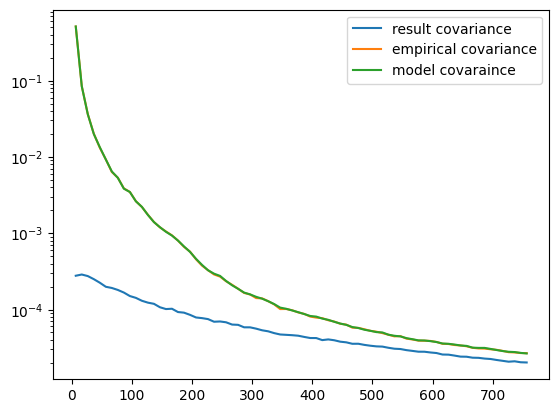

In [385]:
plt.plot(leff,C_result[:,50,50], label="result covariance")
plt.plot(leff, c_hat[:,50,50], label="empirical covariance")
plt.plot(leff, c_model[:,50,50], label="model covaraince")
plt.yscale('log')
plt.legend()

-------Extra Plots---------

Check if the empirical covariance is symmetric and PSD

In [326]:
np.allclose(c_hat[0], c_hat.T[:,:,0],atol=1e-10)

True

In [327]:
eigvals = np.linalg.eigvalsh(c_hat[0])  # eigvalsh for symmetric/hermitian matrices
print("Min eigenvalue:", eigvals.min())

is_psd = eigvals.min() >= -1e-10  # small negative allowed for numerical error
print("Is PSD?", is_psd)

Min eigenvalue: -3.670990266711195e-15
Is PSD? True


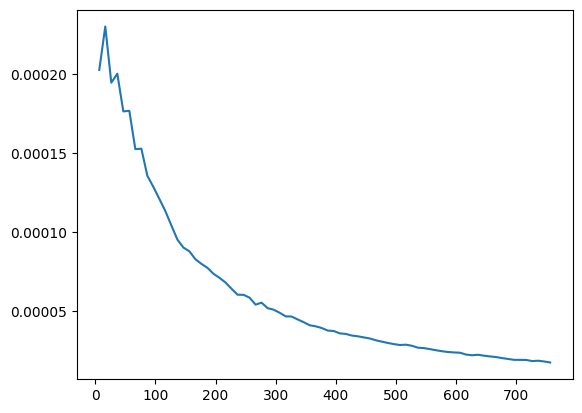

In [347]:

# plt.plot(noise_binned[:,100,100])
plt.plot(leff,hi_binned[:,70,70]+noise_binned[:,70,70])

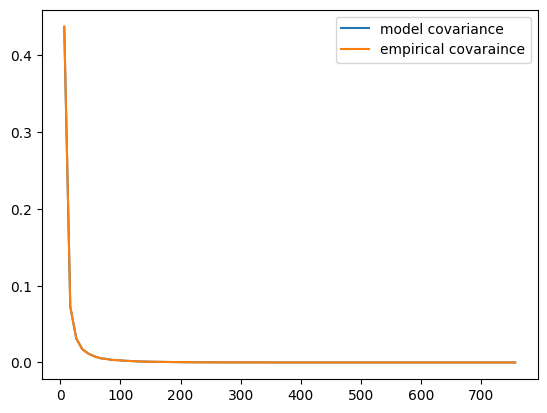

In [346]:
plt.plot(leff,c_model[:,70,70], label="model covariance")
plt.plot(leff,c_hat[:,70,70], label="empirical covaraince")
plt.legend()

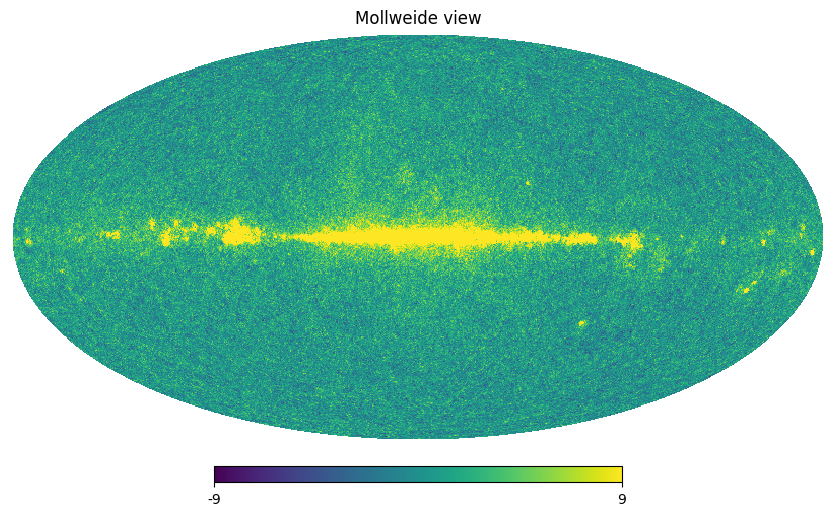

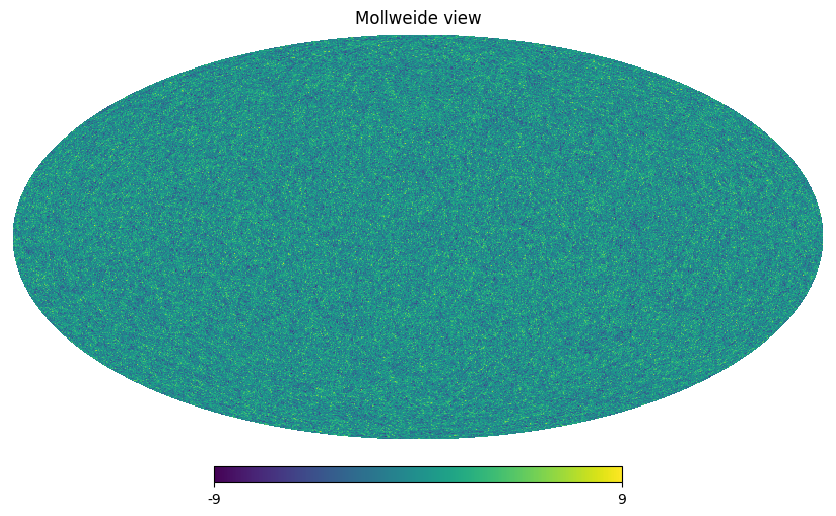

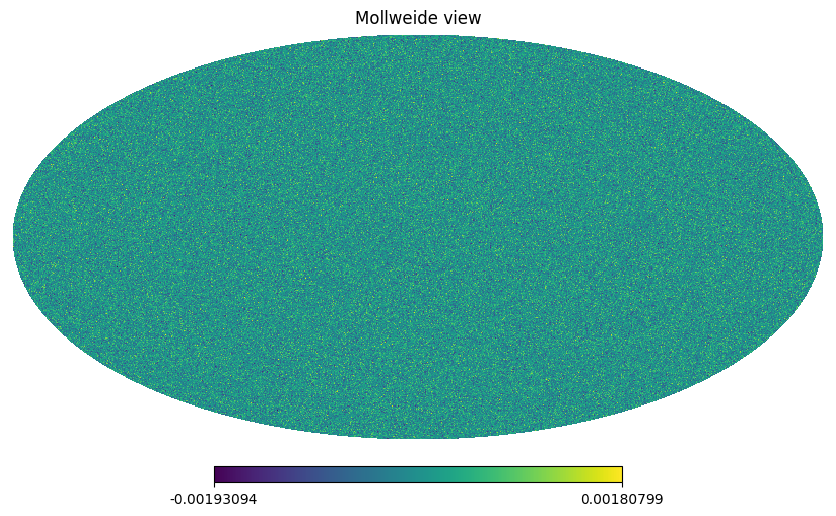

In [348]:
hp.mollview(smoothed_maps[0], min=-9, max=9)
hp.mollview(smoothed_hi_maps[0], min=-9, max=9)
hp.mollview(noise_maps[0])